<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_equalizers_for_IMDD_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test equalizers for IM-DD transmission systems

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import numpy as np
from optic.models.tx import pamTransmitter
from optic.models.devices import photodiode
from optic.models.channels import linearFiberChannel
from optic.comm.metrics import fastBERcalc
from optic.dsp.core import pnorm, signalPower, movingAverage   
from optic.dsp.equalization import dfe, ffe, volterra
from optic.utils import parameters
from optic.plot import eyediagram

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

c:\Users\edson.DESKTOP-54IJM4F\anaconda3\envs\opticommpy-env\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2

### Intensity modulation (IM) with Pulse Amplitude Modulation (PAM)

Average power of the modulated optical signal [dBm]: -3.000 dBm


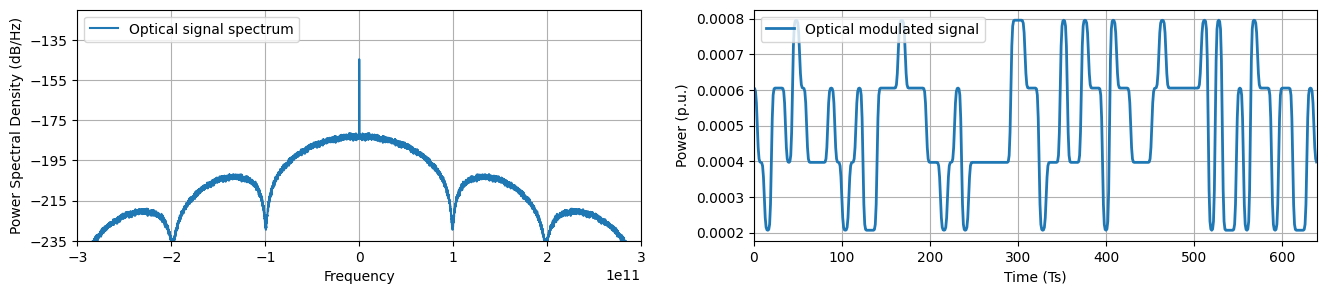

In [15]:
# simulation parameters
paramTx = parameters()
paramTx.M = 4              # modulation order
paramTx.Rs = 100e9         # symbol rate
paramTx.SpS = 8            # samples per symbol
paramTx.seed = 123         # seed for the random number generator
paramTx.nBits = int(np.log2(paramTx.M)*1e5) # total number of bits to transmit
paramTx.pulseType = 'nrz'  # pulse shape type
paramTx.power = -3         # optical output power in dBm
paramTx.mzmScale = 0.20    # MZM modulation scale factor Vrf/Vpi

sigTxo, symbTx = pamTransmitter(paramTx)

Fs = paramTx.SpS * paramTx.Rs  # simulation sampling frequency

print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signalPower(sigTxo)/1e-3)))

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*paramTx.Rs,3*paramTx.Rs);
axs[0].set_ylim(-235,-120);
axs[0].psd(np.abs(sigTxo)**2, Fs=paramTx.SpS*paramTx.Rs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');

interval = np.arange(0, len(sigTxo), 1)
axs[1].plot(np.abs(sigTxo[0:80*paramTx.SpS])**2, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (Ts)')
axs[1].set_xlim(0, 80*paramTx.SpS)
axs[1].legend(loc='upper left')
axs[1].grid()

### Linear fiber channel model (attenuation + chromatic dispersion)

In [16]:
# linear optical channel
paramCh = parameters()
paramCh.L = 1.4        # total link distance [km]
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 17         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

sigCh = linearFiberChannel(sigTxo, paramCh)

### Direct-detection (DD) pin receiver model

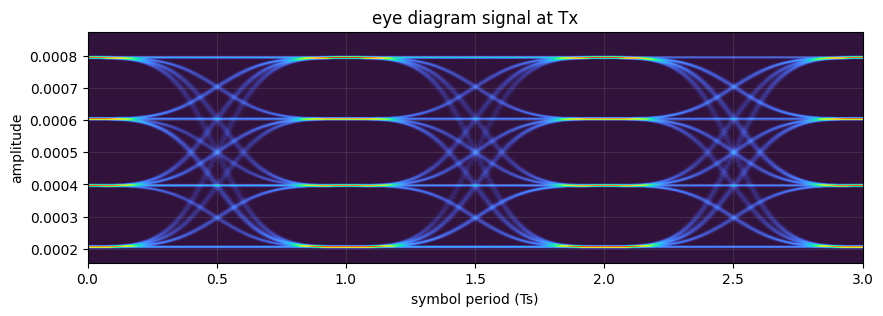

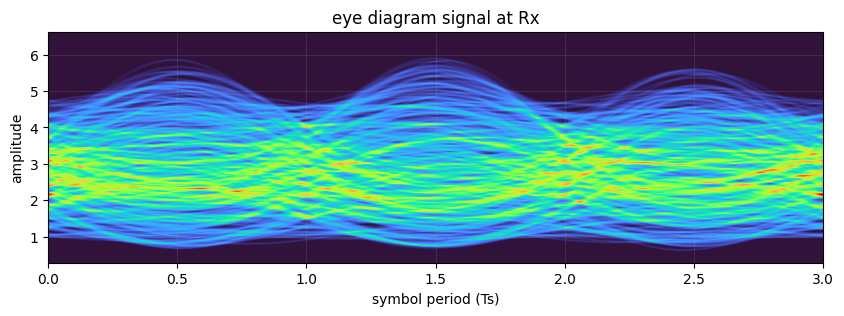

In [17]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
paramPD.Fs = Fs
paramPD.seed = 456
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = paramTx.Rs
paramPD.Fs = Fs
paramPD.seed = 456

I_Rx = photodiode(sigCh, paramPD)

I_Rx = I_Rx/np.std(I_Rx)

# downsample
SpSrx = 2
symbRx = I_Rx[0::paramTx.SpS//SpSrx]

# subtract DC level and normalize power
symbRx = symbRx - symbRx.mean()
symbRx = pnorm(symbRx)

discard = 100*paramTx.SpS
eyediagram(I_Rx_ideal[discard:-discard], I_Rx.size-2*discard, paramTx.SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard], I_Rx.size-2*discard, paramTx.SpS, plotlabel='signal at Rx', ptype='fancy')

### Run different equalization algorithms on the received signal

In [18]:
nTrain = 50000  # number of training symbols
plots = False  # enable/disable plots of equalizer taps and MSE convergence

# Apply DFE equalization
paramDFE = parameters()
paramDFE.nTapsFF = 16
paramDFE.nTapsFB = 14
paramDFE.SpS = SpSrx
paramDFE.mu = 1e-3
paramDFE.nTrain = nTrain
paramDFE.M = paramTx.M

outDFE, f, b, mseDFE = dfe(symbRx, symbTx, paramDFE)
outDFE = pnorm(outDFE)

if plots:
    plt.figure(figsize=(10,3))
    plt.plot(f, 'o-', label='FF taps')
    plt.plot(b, 's-', label='FB taps')
    plt.xlim(0, max(len(f), len(b))-1)
    plt.xlabel('Taps')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()

# Apply FFE equalization
paramFFE = parameters()
paramFFE.nTaps = 30
paramFFE.mu = 2e-3
paramFFE.nTrain = nTrain
paramFFE.SpS = SpSrx
paramFFE.M = paramTx.M

outFFE, h, mseFFE = ffe(symbRx, symbTx, paramFFE)
outFFE = pnorm(outFFE)

if plots:
    plt.figure(figsize=(10,3))
    plt.plot(h, 'o-', label='FFE taps')
    plt.legend()
    plt.xlim(0, len(h)-1)
    plt.xlabel('Taps')
    plt.ylabel('Amplitude')
    plt.grid()

# Aplly Volterra equalization
paramVolterra = parameters()
paramVolterra.n1Taps = 30
paramVolterra.n2Taps = 14
paramVolterra.n3Taps = 10
paramVolterra.SpS = SpSrx
paramVolterra.mu = 2e-2
paramVolterra.order = 3
paramVolterra.nTrain = nTrain

outVolterra, h_volterra, mseVolterra = volterra(symbRx, symbTx, paramVolterra)
h1 = h_volterra[0]
h2 = h_volterra[1]
h3 = h_volterra[2]

outVolterra = pnorm(outVolterra)

if plots:
    plt.figure(figsize=(10,3))
    plt.plot(h1, 'o-', label='Volterra linear taps')
    plt.plot(h2, 's-', label='Volterra 2nd order taps')
    #plt.plot(h3, 'x-', label='Volterra 3rd order taps')
    plt.legend()
    plt.xlim(0, max(len(h1), len(h2))-1)
    plt.xlabel('Taps')
    plt.ylabel('Amplitude')
    plt.grid()

    plt.figure(figsize=(10,3))
    plt.plot(symbRx[::2],'.', label='received symbols')
    plt.plot(outFFE,'.', label='FFE equalized symbols')
    plt.plot(outDFE,'.', label='DFE equalized symbols')
    plt.plot(outVolterra,'.', label='Volterra equalized symbols')
    plt.ylim(-2, 2)
    plt.legend()

    plt.figure(figsize=(10,3))
    plt.plot(10*np.log10(movingAverage(mseDFE, 200)), label='DFE MSE convergence')
    plt.plot(10*np.log10(movingAverage(mseFFE, 200)), label='FFE MSE convergence')
    plt.plot(10*np.log10(movingAverage(mseVolterra, 200)), label='Volterra MSE convergence')
    plt.legend()
    plt.xlim(0, len(mseDFE))
    plt.xlabel('Iterations')
    plt.ylabel('MSE (dB)')
    plt.grid()


### Performance results

In [19]:
# demodulate symbols to bits with minimum Euclidean distance and calculated BER, SER and SNR

# without equalization
discard = 20000
ber, ser, snr = fastBERcalc(symbRx[0::2][discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')

# with FFE equalization
ber_ffe, ser_ffe, snr_ffe = fastBERcalc(outFFE[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')

# with DFE equalization
ber_dfe, ser_dfe, snr_dfe = fastBERcalc(outDFE[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')

# with Volterra equalization
ber_volterra, ser_volterra, snr_volterra = fastBERcalc(outVolterra[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')

# print results table
print('Performance results:')
print('------------------------------------')
print('Method      |  BER       |  SNR (dB)')
print('------------------------------------')
print(f'No EQ       |  {ber[0]:.2e}  |  {snr[0]:.2f} ')
print(f'FFE         |  {ber_ffe[0]:.2e}  |  {snr_ffe[0]:.2f} ')
print(f'DFE         |  {ber_dfe[0]:.2e}  |  {snr_dfe[0]:.2f} ') 
print(f'Volterra    |  {ber_volterra[0]:.2e}  |  {snr_volterra[0]:.2f} ')

Performance results:
------------------------------------
Method      |  BER       |  SNR (dB)
------------------------------------
No EQ       |  1.91e-01  |  5.29 
FFE         |  2.49e-03  |  15.78 
DFE         |  6.79e-04  |  17.80 
Volterra    |  1.29e-03  |  17.16 


### Generate curve of BER vs received input power

In [11]:
# simulation parameters
paramTx = parameters()
paramTx.M = 4              # modulation order
paramTx.Rs = 100e9          # symbol rate
paramTx.SpS = 16           # samples per symbol
paramTx.seed = 123         # seed for the random number generator
paramTx.nBits = int(np.log2(paramTx.M)*1e6) # total number of bits to transmit
paramTx.pulseType = 'nrz'  # pulse shape type
paramTx.power = -3         # optical output power in dBm
paramTx.mzmScale = 0.20    # MZM modulation scale factor Vrf/Vpi

Fs = paramTx.SpS * paramTx.Rs  # simulation sampling frequency

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = paramTx.Rs
paramPD.Fs = Fs
paramPD.seed = 456

# receiver parameters
SpSrx = 2  # samples per symbol at the receiver DSP

powerValues = np.arange(-20,-4) # power values at the input of the pin receiver
ber = np.zeros(powerValues.shape)
ber_wFFE = np.zeros(powerValues.shape)
ber_wDFE = np.zeros(powerValues.shape)
ber_wVolterra = np.zeros(powerValues.shape)
Pb = np.zeros(powerValues.shape)
    
nTrain = 40000

for indPi, Pi_dBm in enumerate(tqdm(powerValues)):
    
    paramTx.power = Pi_dBm # optical signal power at the MZM output

    # generate PAM modulated signal
    sigTxo, symbTx = pamTransmitter(paramTx)

    # pin receiver
    I_Rx = photodiode(sigTxo.real, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # downsample
    symbRx = I_Rx[0::paramTx.SpS//SpSrx ]

    # subtract DC level and normalize power
    symbRx = symbRx - symbRx.mean()
    symbRx = pnorm(symbRx)

    # Apply DFE equalization
    paramDFE = parameters()
    paramDFE.nTapsFF = 5
    paramDFE.nTapsFB = 5
    paramDFE.SpS = SpSrx
    paramDFE.mu = 1e-3
    paramDFE.nTrain = nTrain
    paramDFE.M = paramTx.M

    outDFE,f, b,mseDFE = dfe(symbRx, symbTx.astype(np.float32), paramDFE)
    outDFE = pnorm(outDFE)

    # Apply ffe equalization
    paramFFE = parameters()
    paramFFE.nTaps = 10
    paramFFE.SpS = SpSrx
    paramFFE.mu = 1e-3
    paramFFE.nTrain = nTrain 

    outFFE, h, mseFFE = ffe(symbRx, symbTx, paramFFE)

    # Aplly Volterra equalization
    paramVolterra = parameters()
    paramVolterra.n1Taps = 15
    paramVolterra.n2Taps = 7
    paramVolterra.n3Taps = 5
    paramVolterra.SpS = SpSrx
    paramVolterra.mu = 2e-2
    paramVolterra.order = 3
    paramVolterra.nTrain = nTrain

    outVolterra, h_volterra, mseVolterra = volterra(symbRx, symbTx, paramVolterra)    
    outVolterra = pnorm(outVolterra)

    # demodulate symbols to bits with minimum Euclidean distance and calculated BER, SER and SNR
    discard = nTrain
    
    # without equalization
    ber_, ser, snr = fastBERcalc(symbRx[::SpSrx][discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam') 
    ber[indPi] = ber_[0]

    # with FFE equalization
    ber_ffe, ser_ffe, snr_ffe = fastBERcalc(outFFE[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')
    ber_wFFE[indPi] = ber_ffe[0]

    # with DFE equalization
    ber_eq, ser_eq, snr_eq = fastBERcalc(outDFE[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')
    ber_wDFE[indPi] = ber_eq[0]

    # with Volterra equalization
    ber_volterra, ser_volterra, snr_volterra = fastBERcalc(outVolterra[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')
    ber_wVolterra[indPi] = ber_volterra[0]

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_45704\4089137120.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(ber),'o-',label='BER without EQ')
C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_45704\4089137120.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(ber_wDFE),'s-',label='BER with DFE')
C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_45704\4089137120.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(ber_wFFE),'d-',label='BER with FFE')
C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_45704\4089137120.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(ber_wVolterra),'x-',label='BER with Volterra')


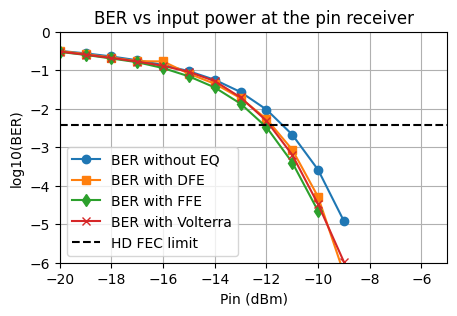

In [12]:
plt.figure(figsize=(5,3))
plt.plot(powerValues, np.log10(ber),'o-',label='BER without EQ')
plt.plot(powerValues, np.log10(ber_wDFE),'s-',label='BER with DFE')
plt.plot(powerValues, np.log10(ber_wFFE),'d-',label='BER with FFE')
plt.plot(powerValues, np.log10(ber_wVolterra),'x-',label='BER with Volterra')
plt.hlines(np.log10(3.8e-3), xmin=min(powerValues), xmax=max(powerValues), colors='k', linestyles='dashed', label='HD FEC limit')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Pin (dBm)');
plt.title('BER vs input power at the pin receiver')
plt.legend();
plt.ylim(-6,0);
plt.xlim(min(powerValues), max(powerValues));

### Generate curve of BER vs transmission distance

In [13]:
# simulation parameters
paramTx = parameters()
paramTx.M = 4              # modulation order
paramTx.Rs = 100e9          # symbol rate
paramTx.SpS = 16           # samples per symbol
paramTx.seed = 123         # seed for the random number generator
paramTx.nBits = int(np.log2(paramTx.M)*1e6) # total number of bits to transmit
paramTx.pulseType = 'nrz'  # pulse shape type
paramTx.power = -3         # optical output power in dBm
paramTx.mzmScale = 0.20    # MZM modulation scale factor Vrf/Vpi

Fs = paramTx.SpS * paramTx.Rs  # simulation sampling frequency

# fiber channel parameters
distance = np.arange(0.8, 1.55, 0.05) # transmission distance in km
paramCh = parameters()
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 17         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = paramTx.Rs
paramPD.Fs = Fs
paramPD.seed = 456

# receiver parameters
SpSrx = 2  # samples per symbol at the receiver DSP

ber = np.zeros(distance.shape)
ber_wFFE = np.zeros(distance.shape)
ber_wDFE = np.zeros(distance.shape)
ber_wVolterra = np.zeros(distance.shape)
Pb = np.zeros(distance.shape)

# generate PAM modulated signal
sigTxo, symbTx = pamTransmitter(paramTx)

nTrain = 40000
for indL, L in enumerate(tqdm(distance)):         
    # linear optical channel   
    paramCh.L = L
    sigCh = linearFiberChannel(sigTxo, paramCh)
 
    # pin receiver
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # downsample received signal
    symbRx = I_Rx[0::paramTx.SpS//SpSrx]

    # subtract DC level and normalize power
    symbRx = symbRx - symbRx.mean()
    symbRx = pnorm(symbRx)

    # Apply FFE equalization
    paramFFE = parameters()
    paramFFE.nTaps = 30
    paramFFE.SpS = SpSrx
    paramFFE.mu = 1e-3
    paramFFE.nTrain = nTrain
    paramFFE.M = paramTx.M

    outFFE, h, mse = ffe(symbRx, symbTx, paramFFE)
    outFFE = pnorm(outFFE)

    # Apply DFE equalization
    paramDFE = parameters()
    paramDFE.nTapsFF = 16
    paramDFE.nTapsFB = 14
    paramDFE.SpS = SpSrx
    paramDFE.mu = 1e-3
    paramDFE.nTrain = nTrain
    paramDFE.M = paramTx.M

    outDFE,f, b, mse = dfe(symbRx, symbTx, paramDFE)
    outDFE = pnorm(outDFE)

   # Aplly Volterra equalization
    paramVolterra = parameters()
    paramVolterra.n1Taps = 30
    paramVolterra.n2Taps = 14
    paramVolterra.n3Taps = 10
    paramVolterra.SpS = SpSrx
    paramVolterra.mu = 2e-2
    paramVolterra.order = 3
    paramVolterra.nTrain = nTrain

    outVolterra, h_volterra, mseVolterra = volterra(symbRx, symbTx, paramVolterra)
    outVolterra = pnorm(outVolterra)
    
    # demodulate symbols to bits with minimum Euclidean distance and calculated BER, SER and SNR
    discard = nTrain

    # without equalization  
    ber_, ser, snr = fastBERcalc(symbRx[::SpSrx][discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam') 
    ber[indL] = ber_[0]

    # with FFE equalization
    ber_ffe, ser_ffe, snr_ffe = fastBERcalc(outFFE[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')
    ber_wFFE[indL] = ber_ffe[0]

    # with DFE equalization
    ber_eq, ser_eq, snr_eq = fastBERcalc(outDFE[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')
    ber_wDFE[indL] = ber_eq[0]

    # with Volterra equalization
    ber_volterra, ser_volterra, snr_volterra = fastBERcalc(outVolterra[discard:-discard//10], symbTx[discard:-discard//10], paramTx.M, 'pam')
    ber_wVolterra[indL] = ber_volterra[0]

  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_45704\2668253101.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(distance, np.log10(ber_wFFE),'d-',label='BER with FFE')
C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_45704\2668253101.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(distance, np.log10(ber_wDFE),'s-',label='BER with DFE')
C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_45704\2668253101.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(distance, np.log10(ber_wVolterra),'x-',label='BER with Volterra')


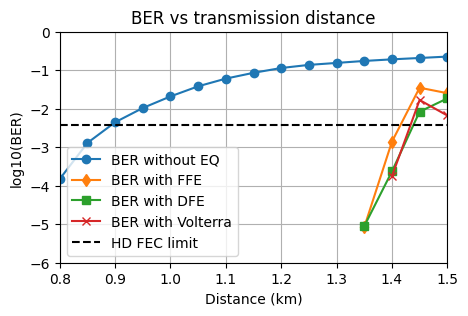

In [14]:
plt.figure(figsize=(5,3))
plt.plot(distance, np.log10(ber),'o-',label='BER without EQ')
plt.plot(distance, np.log10(ber_wFFE),'d-',label='BER with FFE')
plt.plot(distance, np.log10(ber_wDFE),'s-',label='BER with DFE')
plt.plot(distance, np.log10(ber_wVolterra),'x-',label='BER with Volterra')
plt.hlines(np.log10(3.8e-3), xmin=min(distance), xmax=max(distance), colors='k', linestyles='dashed', label='HD FEC limit')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Distance (km)');
plt.title('BER vs transmission distance')
plt.legend(loc='lower left');
plt.ylim(-6,0);
plt.xlim(min(distance), max(distance));